# BERT fine tunning

На основе *Based on [BERT Fine-Tuning Sentence Classification notebook on Colab](https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=6J-FYdx6nFE_), refined by [Anastasia Ianina](https://www.linkedin.com/in/anastasia-ianina/)*, доработанной Анастасией Яниной

Мы будем использовать реализацию BERT из библиотеки pytorch-transformers, которая содержит почти все последние архитектуры.

In [1]:
! pip install pytorch-transformers
! wget -O negative.csv 'https://www.dropbox.com/s/qwp22e0t3d3n2xa/negative.csv?dl=0'
! wget -O positive.csv 'https://www.dropbox.com/s/t6nxxuplzsyica6/positive.csv?dl=0'

--2020-12-02 14:26:10--  https://www.dropbox.com/s/qwp22e0t3d3n2xa/negative.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qwp22e0t3d3n2xa/negative.csv [following]
--2020-12-02 14:26:11--  https://www.dropbox.com/s/raw/qwp22e0t3d3n2xa/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2020-12-02 14:26:11 ERROR 404: Not Found.

--2020-12-02 14:26:11--  https://www.dropbox.com/s/t6nxxuplzsyica6/positive.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t6nxxuplzsyica6/positive.csv [following]
--2020-12-02 14:26:11--  

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

Если у вас есть GPU, будем использовать ее для обучения. Тем не менее, этот ноутбук можно выполнить и с помощью только CPU. Правда, это будет значительно дольше.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla T4 GPUs


In [4]:
# device = torch.device('cpu')

## Загрузка данных

Мы выбрали не очень известный, необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [5]:
import pandas as pd

In [6]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

In [10]:
data.shape

(159571, 2)

In [11]:
# Уменьшаем выборку
df_tweets = data.sample(100000).reset_index(drop=True) 

pos_texts = df_tweets.loc[df_tweets['toxic'] == 0]
neg_texts = df_tweets.loc[df_tweets['toxic'] == 1]

In [12]:
df_tweets.sample(5)

,text,toxic
8908,Link worked fine for me too: http://www.washin...,0
89039,I want to share something with you \n\nHere is...,0
72824,Y was the Libertyville Icecats hockey page del...,0
93523,WP:EL is not clear on this at all. There is no...,0
68425,No I'm not gone hahahahahahahaha!!!!!! but not...,1


Обратите внимание на специальные токены [CLS] и [SEP], которые мы добавляем в началои конец предложения.

In [13]:
sentences = df_tweets['text'].values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_tweets['toxic'].values

In [14]:
assert len(sentences) == len(labels)

In [15]:
print(sentences[100])

[CLS] Wikipedia:Miscellany for deletion/Book:Mystery 

As the user who created Wikipedia:Proposed deletion (books), you are very experienced with Wikipedia books. Would you provide input at Wikipedia:Miscellany for deletion/Book:Mystery? I am unfamiliar with policies regarding books and am unsure whether a vague name is a reason for deletion or whether a rename should be done. The discussion is at Wikipedia:Miscellany for deletion/Book:Mystery. [SEP]


In [16]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2)

In [17]:
print(len(train_gt), len(test_gt))

80000 20000


## Inputs
Теперь импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [18]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'sparta', '##z', ',', 'what', 'is', 'sub', '##op', '##ti', '##mal', 'is', 'an', 'ad', '##min', 'getting', 'away', 'with', 'the', 'behavior', 'engaged', 'in', 'by', 'rd', '##23', '##2', '.', 'please', 'by', 'all', 'means', 'file', 'a', 'report', 'on', 'his', 'actions', 'and', 'let', "'", 's', 'get', 'to', 'the', 'bottom', 'of', 'why', 'he', 'edit', 'war', '##red', '8', 'or', 'nine', 'times', 'against', 'two', 'unrelated', 'editors', ',', 'then', 'did', 'another', 'rev', '##ert', 'of', 'unrelated', 'content', 'and', 'blocked', 'over', 'it', 'despite', 'his', 'involvement', '.', 'i', 'will', 'certainly', 'observe', 'the', 'utmost', 'decor', '##um', 'once', 'i', 'witness', 'an', 'attempt', 'to', 'address', 'his', 'numerous', 'mis', '##dee', '##d', 'including', 'harassment', ',', 'edit', 'warring', ',', 'involved', 'blocking', ',', 'and', 'making', 'numerous', 'false', 'sm', '##ears', '.', 'and', 'as', 'i', 'recall', 'you', 'rendered', 'several', 'bad', 'af', '##d', 'decisions', '

BERT'у нужно предоставить специальный формат входных данных.

   - **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре,
   - **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
   - **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.,
   - **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.
   
Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет 150).

Теперь более длинные предложения будем обрезать до 150 токенов, а для более коротких использовать паддинг. Возьмем готовую функцию pad_sequences из библиотеки keras.

In [19]:
input_ids = [tokenizer.convert_tokens_to_ids(x[:150]) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Делим данные на train и val:

In [20]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Преобразуем данные в pytorch тензоры:

In [21]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [22]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [23]:
train_labels

tensor([0, 0, 1,  ..., 0, 0, 1])

Воспользуемся классом DataLoader. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler. Также обратите внимание на размер батча: если во время тренировки возникнет Memory Error, размер батча необходимо уменьшить.

In [24]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=40
)

In [25]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=40
)

## Обучение модели

Теперь когда данные подготовлены, надо написать пайплайн обучения модели.

Для начала мы хотим изменить предобученный BERT так, чтобы он выдавал метки для классификации текстов, а затем файнтюнить его на наших данных. Мы возьмем готовую модификацию BERTа для классификации из pytorch-transformers. Она интуитивно понятно называется BertForSequenceClassification. Это обычный BERT с добавленным линейным слоем для классификации.

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [26]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач. Все они построены на основе одной и той же архитектуры и различаются только верхними слоями.

In [27]:
#from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

Теперь подробнее рассмотрим процесс файн-тюнинга. Как мы помним, первый токен в каждом предложении - это [CLS]. В отличие от скрытого состояния, относящего к обычному слову (не метке [CLS]), скрытое состояние относящееся к этой метке должно содержать в себе аггрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом будет вектор со скрытым состоянием, относящийся к метке [CLS]. Дополнительный полносвязный слой, который мы добавили, имеет размер [hidden_state, количество_классов], в нашем случае количество классов равно двум. То есть нав выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска" и "отрицательная эмоциональная окраска".

Процесс дообучения достаточно дешев. По факту мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях в процессе, чтобы подстроиться под нашу задачу.

Иногда некоторые слои специально "замораживают" или применяют разные стратегии работы с learning rate, в общем, делают все, чтобы сохранить "хорошие" веса в нижних слоях и ускорить дообучение. В целом, замораживание слоев BERTа обычно не сильно сказывается на итоговом качестве, однако надо помнить о тех случаях, когда данные, использованные для предобучения и дообучения очень разные (разные домены или стиль: академическая и разговорная лексика). В таких случаях лучше тренировать все слои сети, не замораживая ничего.

Загружаем BERT. bert-base-uncased - это версия "base" (в оригинальной статье рассказывается про две модели: "base" vs "large"), где есть только буквы в нижнем регистре ("uncased").

In [28]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Теперь обсудим гиперпараметры для обучения нашей модели. Авторы статьи советуют выбирать learning rate 5e-5, 3e-5, 2e-5, а количество эпох не делать слишком большим, 2-4 вполне достаточно. Мы пойдем еще дальше и попробуем дообучить нашу модель всего за одну эпоху.

In [29]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

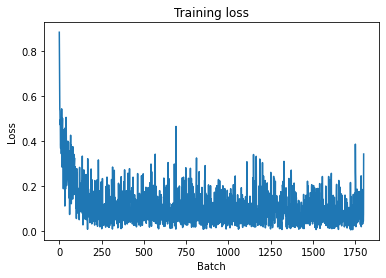

Loss на обучающей выборке: 0.10683


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Процент правильных предсказаний на валидационной выборке: 96.99%


In [30]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [31]:
print("f1_score: {0:.2f}%".format(
    f1_score(valid_labels, valid_preds)
))

f1_score: 0.85%


## Оценка качества на отложенной выборке

Качество на валидационной выборке оказалось очень хорошим. Не переобучилась ли наша модель?

Делаем точно такую же предобработку для тестовых данных, как и в начале ноутбука делали для обучающих данных:

In [38]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x[:150]) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)

Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1085 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1130 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (879 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (935 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Создаем attention маски и приводим данные в необходимый формат:

In [39]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [40]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [41]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 96.78%


In [42]:
f1_score(test_labels, test_preds)

0.8414574101427869

In [43]:
from sklearn.metrics import recall_score, precision_score

print('1 эпоха: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
))

1 эпоха: точность (precision) 83.90%, полнота (recall) 84.40%
